# Appendix XX - Re-fitting the repressor binding energies to the Garcia & Phillips, 2011 data.

In [100]:
# For operating system interaction
import os
import glob
import datetime
import sys
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_format = 'svg'

#### $\LaTeX$ commands
$\newcommand{\foldchange}{\text{fold-change}}$
$\newcommand{\mm}{\left\langle m \right\rangle}$
$\newcommand{\Nns}{N_{NS}}$
$\newcommand{\Ns}{N_{S}}$
$\newcommand{\pact}{p_{\text{act}}}$
$\newcommand{\Rs}{\left\langle R_S \right\rangle}$
$\newcommand{\Rns}{\left\langle R_{NS} \right\rangle}$
$\newcommand{\Rt}{\left\langle R_{\text{tot}} \right\rangle}$
$\newcommand{\eRA}{\Delta\varepsilon_{RA}}$

## Fitting $\eRA$ to original LacI titration data.

Given the discrepancies between the O3 data and the theoretical predictions we decided to explore if a single parameter could explain the disagreement.

The current hypothesis is that a change in the $\eRA$ parameter would suffice to explain the difference between theory and experiment. To test this idea we will use the original data from Garcia & Phillips, 2011 PNAS paper from which the binding energies were originally obtained.

Let's first import the data.

In [101]:
df_HG = pd.read_csv('../../data/tidy_Garcia_2011_raw_data.csv')
df_HG.dropna(axis=0, inplace=True)
df_HG.repressors = df_HG.repressors * 2
df_HG[['operator', 'repressors', 'fold_change']].head()

,operator,repressors,fold_change
0,Oid,1220.0,0.000221
1,O1,1220.0,0.001294
2,O2,1220.0,0.006133
3,Oid,22.0,0.006691
4,O1,22.0,0.037764


Just as a reminder of how the data looks like, let's plot the raw data.

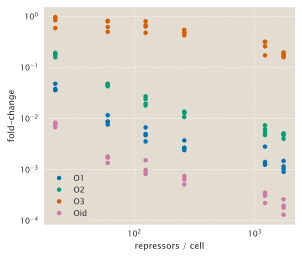

In [102]:
df_group = df_HG.groupby('operator')

fig = plt.figure()
for group, data in df_group:
    plt.plot(data.repressors, data.fold_change, 'o', markersize=4.5, lw=0,
             label=group)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('repressors / cell')

fig.set_size_inches(4.5, 4)
plt.ylabel('fold-change')

It is important to highlight that the relevant scale to plot this data is on a log-log scale. This is an important issue that will be relevant when we perform our fits for the binding energy.

### Computing the posterior probability $P(\Delta\varepsilon_{RA} \mid D)$

We will use a log posterior probability where we assumed a Gaussian likelihood with a single parameter $\sigma$ for the error. After integrating this parameter out the log posterior takes the form
$$
\ln P(\tilde{k_A}, \tilde{k_I} \mid D, I) \propto \frac{n}{2} \ln \left[ \sum_{i=1}^n \left( fc_{exp}^{(i)} - fc\left(\tilde{k_A}, \tilde{k_I}, R^{(i)}, \Delta\varepsilon_{RA}^{(i)}, C^{(i)} \right) \right)^2 \right],
\tag{1}
$$
where $\tilde{k_X} \equiv -\ln K_X$ with $X \in \{A, I \}$, and $n$ being the number of data points. This is analogous to the classic maximum likelihood approach.

Let's define a function to compute this.

In [103]:
def log_post_epsilon(epsilon_r, R, fc_exp, epsilon=4.5, log=False):
    '''
    Computes the log-likelihood
    Parameters
    ----------
    epsilon_r : float.
        Value of the repressor-DNA binding energy
    R : array-like.
        Repressor copy number
    fc_exp : array-like.
        Experimental fold-change
    epsilon : float.
        Free energy difference between active and inactive repressor
    log : bool.
        Boolean indicating if the difference between prediction and data should
        be taken in log scale. DEFAULT = False.
    
    Returns
    -------
    log likelihood.
    '''
    # Compute the theoretical fold,change
    fc_theory = mwc.fold_change_log(iptg=np.array([0]),
                                    ea=-np.log(139),
                                    ei=-np.log(0.53),
                                    epsilon=epsilon,
                                    R=R,
                                    epsilon_r=epsilon_r,
                                    quaternary_state=1)
    
    if log:
        return - len(fc_exp) / 2 * \
        np.log(np.sum((np.log(fc_theory) - np.log(fc_exp))**2))
    else:
        return - len(fc_exp) / 2 * np.log(np.sum((fc_theory - fc_exp)**2))

A **key** argument of this function is the boolean `log` entry. What this option allows us to do is to take the difference between the theoretical and experimental fold-change or take the difference of the log of each of these quantities.

As mentioned before the scale which makes sense to plot the LacI titration data is on a log-log scale. Therefore if one performs the parameter fit more weight is given to the fold-change measurements done at lower repressor copy numbers since the fold-change numbers are by definition larger.

Let's compare this statement. In the next plot we will compute the non-normalized probability $P(\eRA \mid D)$ when taking the data as the fold-change (solid line) or as the log of the fold-change (dotted line).

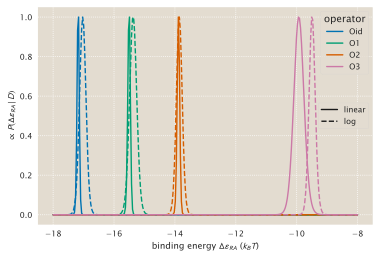

In [179]:
operators = df_HG.operator.unique()
colors = sns.color_palette('colorblind', n_colors=len(operators))

fig = plt.figure()
for j, op in enumerate(operators):
    # Extract the operator data and split it by variable
    df_op = df_HG[df_HG.operator == op]
    R = df_op.repressors.values
    fc_exp = df_op.fold_change.values
    epsilon_r_array = np.linspace(-18, -8, 300)

    lp = np.empty_like(epsilon_r_array)
    lp_log = np.empty_like(epsilon_r_array)
    for i, eps in enumerate(epsilon_r_array):
        lp[i] = log_post_epsilon(eps, R, fc_exp, log=False)
        lp_log[i] = log_post_epsilon(eps, R, fc_exp, log=True)

    lp = lp - lp.max()
    lp_log = lp_log - lp_log.max()
    plt.plot(epsilon_r_array, np.exp(lp), label=op, color=colors[j])
    plt.plot(epsilon_r_array, np.exp(lp_log), label=None, color=colors[j],
             ls='--')
# Include main legend indicating operator
main_legend = plt.legend(title='operator')

# Include extra legend defining fit type
l1 = plt.plot([], [], color='k', ls='-', label='linear')
l2 = plt.plot([], [], color='k', ls='--', label='log')
extra_legend = [l1, l2]

labels = ['linear', 'log']
leg = plt.legend([l[0] for l in extra_legend], labels, loc='right')

plt.gca().add_artist(main_legend)

plt.xlabel('binding energy $\Delta\epsilon_{RA}$ ($k_BT$)')
plt.ylabel('$\propto \; P(\Delta \epsilon_{RA} \mid D)$')

From this plot we can see that there is a systematic shift to higher energy values when we consider our data as $\log(\foldchange)$. The fact that the difference is the most noticeable for the case of the O3 operator is interesting since this is the operator with the largest discrepancies in our inducer titration data.

Let's find the most likely parameter value for these distributions.

## Compute the most likely energy value

To compute the most likely parameter we need to define a function that computes the residuals. This will be used by a least-square routine to minimize the sum of the square of the residuals. Again we will include an argument `log` in order to compute the difference of $\foldchange$ or $\log(\foldchange)$.

In [57]:
def resid_epsilon(epsilon_r, R, fc_exp, epsilon=4.5, log=False):
    '''
    Computes the log-likelihood
    Parameters
    ----------
    epsilon_r : float.
        Value of the repressor-DNA binding energy
    R : array-like.
        Repressor copy number
    fc_exp : array-like.
        Experimental fold-change
    epsilon : float.
        Free energy difference between active and inactive repressor
    log : bool.
        Boolean indicating if the difference between prediction and data should
        be taken in log scale. DEFAULT = False.
    Returns
    -------
    residuals
    '''
    # Compute the theoretical fold,change
    fc_theory = mwc.fold_change_log(iptg=np.array([0]), 
                                    ea=-np.log(139),
                                    ei=-np.log(0.53),
                                    epsilon=epsilon,
                                    R=R,
                                    epsilon_r=epsilon_r,
                                    quaternary_state=1)
    
    if log: 
        return np.log(fc_theory) - np.log(fc_exp)
    else:
        return fc_theory - fc_exp

Let's now use this function with the LacI titration data. We will fit the energy for both, the linear and the log fold-change.

In [190]:
operators = df_HG.operator.unique()
# Initialize to save parameter values
epsilon_r = np.empty_like(operators)
epsilon_r_log = np.empty_like(operators)
# Define extra arguments for residual function
epsilon = 4.5

for j, op in enumerate(operators):
    # Extract the operator data and split it by variable
    df_op = df_HG[df_HG.operator == op]
    R = df_op.repressors.values
    fc_exp = df_op.fold_change.values
    args = (R, fc_exp, epsilon, False)
    epsilon_r[j] = scipy.optimize.leastsq(resid_epsilon, -10, args)[0][0]
    args = (R, fc_exp, epsilon, True)
    epsilon_r_log[j] = scipy.optimize.leastsq(resid_epsilon, -10, args)[0][0]

epsilon_dict = dict(zip(operators, epsilon_r.astype(np.double).round(1)))
epsilon_dict_log = dict(zip(operators, epsilon_r_log.astype(np.double).round(1)))
# print(pandas.epsilon_dict)
# print(epsilon_dict_log)
df_epsilon = pd.DataFrame.from_dict(epsilon_dict, orient='index')
df_epsilon_log = pd.DataFrame.from_dict(epsilon_dict_log, orient='index')
df_epsilon = pd.concat([df_epsilon, df_epsilon_log], axis=1)
df_epsilon.columns = ['linear', 'log']
df_epsilon

,linear,log
Oid,-17.2,-17.0
O1,-15.5,-15.4
O2,-13.9,-13.9
O3,-9.9,-9.5


All of the obtained energies are within 0.2 $k_BT$ from the ones originally reported by Garcia & Phillips 2011. Reasons for the discrepancy could involve fitting to the linear mean fold-change weighting by the the inverse variance of each of the repressor copy numbers, i.e., taking the mean at each repressor copy number and dividing by the standard deviation.

Let's now plot the theoretical predictions along the data. We will again show the result from using the linear (solid line) and the log fold-change (dotted line) side to side.

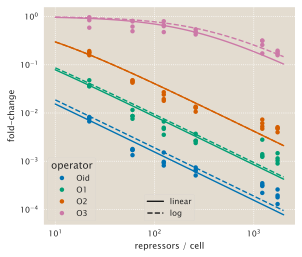

In [191]:
# Define colors to use
colors = sns.color_palette('colorblind', n_colors=len(operators))

# Define repressor array to evaluate
R_array = np.logspace(1, np.log10(2000), 50)

fig = plt.figure()

for i, op in enumerate(operators):
    # Extract the operator data and split it by variable
    data = df_HG[df_HG.operator == op]
    # Compute theoretical fold-change
    # Linear
    fc_thry = mwc.fold_change_log(iptg=np.array([0]),
                                  ea=-np.log(139),
                                  ei=-np.log(0.53),
                                  epsilon=epsilon,
                                  R=R_array,
                                  epsilon_r=epsilon_dict[op],
                                  quaternary_state=1)
    # Log
    fc_thry_log = mwc.fold_change_log(iptg=np.array([0]),
                                  ea=-np.log(139),
                                  ei=-np.log(0.53),
                                  epsilon=epsilon,
                                  R=R_array,
                                  epsilon_r=epsilon_dict_log[op],
                                  quaternary_state=1)
    
    # Plot theoretical prediciton
    plt.plot(R_array, fc_thry, color=colors[i])
    plt.plot(R_array, fc_thry_log, color=colors[i], ls='--')
    # Plot experimental data
    plt.plot(data.repressors, data.fold_change, 'o', markersize=4.5, lw=0,
             label=op, color=colors[i])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('repressors / cell')

# Include main legend indicating operator
main_legend = plt.legend(title='operator')

# Include extra legend defining fit type
l1 = plt.plot([], [], color='k', ls='-', label='linear')
l2 = plt.plot([], [], color='k', ls='--', label='log')
extra_legend = [l1, l2]

labels = ['linear', 'log']
leg = plt.legend([l[0] for l in extra_legend], labels, loc='lower center')

plt.gca().add_artist(main_legend)

fig.set_size_inches(4.5, 4)
plt.ylabel('fold-change')

We can see here that taking the linear fold-change causes the fit to pass exactly through the middle of the lowest repressor copy number data. That is because of the argument that we explained before where more weight is given to these data points since in a linear scale the fold-change differences are much larger at this repressor copy number. Nevertheless the differences are truly minimal.

Let's now turn to fit the values of the dissociation constants for the inducer.

## Fit $K_A$ and $K_I$

Now that we have the updated values for the binding energies we will follow the same procedure of fitting the repressor-inducer dissociation constants for the active ($K_A$) and the inactive state ($K_I$).

Let's define the log-posterior function for these parameters. This will take the same form as the previous log posterior since we again assume a Gaussian likelihood with constant error $\sigma$.

In [197]:
def log_post_kaki(param, indep_var, fc_exp, epsilon=4.5):
    '''
    Computes the log posterior for a single set of parameters.
    Parameters
    ----------
    param : array-like.
        param[0] = epsilon_a
        param[1] = epsilon_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    fc_exp : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        free energy difference between active and inactive states.
    Returns
    -------
    log_post : float.
        the log posterior probability
    '''
    # unpack parameters
    ea, ei = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var[:, 0], indep_var[:, 1], indep_var[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(iptg=IPTG, 
                                    ea=ea,
                                    ei=ei,
                                    epsilon=epsilon,
                                    R=R,
                                    epsilon_r=epsilon_r,
                                    quaternary_state=1)
    
    # return the log posterior
    return -len(fc_exp) / 2 * np.log(np.sum((fc_exp - fc_theory)**2))

Having defined the function let's read all of the available flow data including the Oid operator data.

**Manuel NOTE:** At this point I am going to do something that will be extremely controversial. I have claimed before that the data point at 1 $\mu$M seems to be way off for our theoretical predictions and that is in my opinion the single data point that profoundly biases the perception of the performance of the theory.

But why would I remove this data point? This concentration was only used for the O3 IPTG titration runs. We decided to replace the highest concentration (5000 $\mu$M) for something that would allow us to get better the steep part of the curve. Unfortunately we did not prepare a stock solution of this concentration as with the other ones. Each person performing the run chose to dilute one of the other IPTG aliquots with higher concentrations in order to aim for the desired concentration. Looking through our lab notebook notes I couldn't find any entry in which any of us explained how this dilution was made.

My point for removing it is to show how **in my opinion** the "provocative discrepancies" between the data and the theory are for the most part biased by that single data point. This is an exploratory exercise, therefore I will continue with this.

In [194]:
# Define working directory
datadir = '../../data/'
# List files to be read
files = ['flow_master.csv', 'merged_Oid_data_foldchange.csv']
# Read flow cytometry data
df_Oid = pd.read_csv(datadir + files[1], comment='#')
# make an extra column to have consistent labeling
df_Oid['fold_change_A'] = df_Oid.fold_change
# Remove manually the outlier with an unphysical fold-change
df_Oid = df_Oid[df_Oid.fold_change_A <= 1]
# Read the flow cytometry data
df = pd.read_csv(datadir + files[0], comment='#')
# Attach both data frames into a single one
df = pd.concat([df, df_Oid])
# Drop rows containing NA values
df.dropna(axis=1, inplace=True)

# Change the repressor copy number to be number of dimers
df.repressors = df.repressors * 2

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]

##### Remove the weird concentration (for now)
df = df[df.IPTG_uM != 1]

df[['IPTG_uM', 'fold_change_A', 'operator', 'repressors']].head()


,IPTG_uM,fold_change_A,operator,repressors
2,0.0,0.007146,O2,1740
3,0.0,0.006847,O2,1220
4,0.0,0.013059,O2,260
5,0.0,0.021853,O2,124
6,0.0,0.041988,O2,60


As in the main text let's fit the dissociation constants $K_A$ and $K_I$ to the O2-RBS1027 data.

First let's plot the log posterior to have an idea of where the most probable parameters might live.

In [202]:
ea, ei

(-4.9393034382827494, 0.62535138881570929)

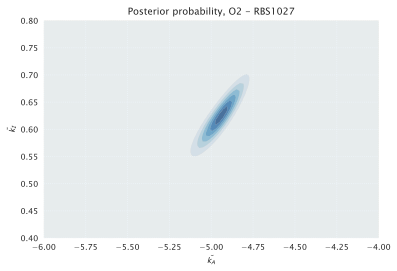

In [204]:
# Extract the O2 RBS1027 data
rbs = df[(df.operator == 'O2') & (df.rbs == 'RBS1027')]

# Parameter values to plot
ea = np.linspace(-6, -4, 100)
ei = np.linspace(0.8, 0.4, 100)

# make a grid to plot
ea_grid, ei_grid = np.meshgrid(ea, ei)

# compute the log posterior
indep_var = rbs[['IPTG_uM', 'repressors']]
indep_var = indep_var.assign(binding_energy=np.repeat(epsilon_dict['O2'],
                                                      len(indep_var)))
indep_var.repressors = indep_var.repressors
fc_exp = rbs['fold_change_A']

log_posterior = np.empty_like(ea_grid)
for i in range(len(ea)):
    for j in range(len(ei)):
        log_posterior[i, j] = log_post_kaki([ea_grid[i, j], ei_grid[i, j]],
                                            indep_var.values, fc_exp.values)

# Get things to scale better
log_posterior -= log_posterior.max()

# plot the results
plt.figure()
plt.contourf(ea_grid, ei_grid, np.exp(log_posterior), alpha=0.7,
             cmap=plt.cm.Blues)
plt.xlabel(r'$\tilde{k_A}$')
plt.ylabel(r'$\tilde{k_I}$')
plt.title('Posterior probability, O2 - RBS1027')

Now let's define again a function to compute the residuals in order to find the peak of the posterior distribution.

In [205]:
def resid_kaki(param, indep_var, fc_exp, epsilon=4.5, log=False):
    '''
    Computes the log posterior for a single set of parameters.
    Parameters
    ----------
    param : array-like.
        param[0] = epsilon_a
        param[1] = epsilon_i
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    fc_exp : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        free energy difference between active and inactive states.
    Returns
    -------
    log_post : float.
        the log posterior probability
    '''
    # unpack parameters
    ea, ei = param
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var[:, 0], indep_var[:, 1], indep_var[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(iptg=IPTG, 
                                    ea=ea,
                                    ei=ei,
                                    epsilon=epsilon,
                                    R=R,
                                    epsilon_r=epsilon_r,
                                    quaternary_state=1)
    
    # return the residuals
    if log:
        return np.log(fc_exp) - np.log(fc_theory)
    else:
        return fc_exp - fc_theory

Let's now use this function to find the most likely values of the dissociation constants. We will do this for both the linear and the log fit of the $\eRA$ parameter.

In [206]:
# Extract the O2 RBS1027 data
rbs = df[(df.operator == 'O2') & (df.rbs == 'RBS1027')]

# compute the log posterior
# Linar
indep_var = rbs[['IPTG_uM', 'repressors']]
indep_var = indep_var.assign(binding_energy=np.repeat(epsilon_dict['O2'],
                                                      len(indep_var)))
fc_exp = rbs['fold_change_A']

# Log
indep_var_log = rbs[['IPTG_uM', 'repressors']]
indep_var_log = indep_var.assign(binding_energy=np.repeat(epsilon_dict_log['O2'],
                                                      len(indep_var)))

# Initial guess
p0 = np.array([-5, 0.6]) # From plotting the posterior

# Extra arguments given as tuple 
# linear
args = (indep_var.values, fc_exp.values, 4.5, False)
# log
args_log = (indep_var_log.values, fc_exp.values, 4.5, False)

# Compute the MAP 
popt, _ = scipy.optimize.leastsq(resid_kaki, p0, args=args)
popt_log, _ = scipy.optimize.leastsq(resid_kaki, p0, args=args_log)

# Extract the values
ea, ei = popt
ea_log, ei_log = popt_log

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} uM
Ki = {1:.3f} uM
Ka (log) = {2:.2f} uM
Ki (log) = {3:.3f} uM
""".format(np.exp(-ea), np.exp(-ei), np.exp(-ea_log), np.exp(-ei_log)))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 139.67 uM
Ki = 0.535 uM
Ka (log) = 139.67 uM
Ki (log) = 0.535 uM



Not surprisingly the parameters are exactly the same. That is to be expected if the fit is performed on any of the O2 strains since the binding energy $\eRA$ was exactly the same when considering the linear and log fold-change. Also expected these are the exact same values we report in the main text of the paper.

The next plot is the key issue to all this document. Remember that the only difference so far has been fitting $\eRA$ using $\foldchange$ and $\log(\foldchange)$ as our data. Other than that the $K_A$ and $K_I$ values remain the same. 

The other significance difference so far is the artificial removal of the point that I consider spurious. The only point I want to make by doing that is that there is no clear trend in which the theory systematically fails to predict O3.

Let's plot the IPTG titrations both using the energies reported by Garcia & Phillips, 2011 (solid linej) and the ones obtained fitting to the raw data considering the log of the fold-change (dotted line).

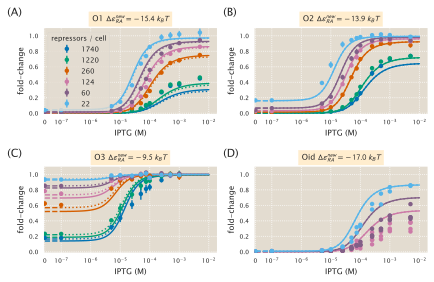

In [207]:
# Define the IPTG concentrations to evaluate
IPTG = np.logspace(-7, -2, 100)
IPTG_lin = np.array([0, 1E-7])

# Set the colors for the strains
colors = sns.color_palette('colorblind', n_colors=7)
colors[4] = sns.xkcd_palette(['dusty purple'])[0]

# Define the operators and their respective energies
operators = ['O1', 'O2', 'O3', 'Oid']
energies = {'O1': -15.3, 'O2': -13.9, 'O3': -9.7, 'Oid': -17.0}

# Initialize the plot to set the size
fig, ax = plt.subplots(2, 2, figsize=(6, 4))
ax = ax.ravel()

# Loop through operators
for i, op in enumerate(operators):
    data = df[df.operator == op]
    # loop through RBS mutants
    for j, rbs in enumerate(df.rbs.unique()):
        # Check if the RBS was measured for this operator
        if rbs in data.rbs.unique():
            # plot the theory using the parameters from the fit.
            # %% Fit in linear scale
            # Log scale plot
            ax[i].plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
                                                 ea=ea,
                                                 ei=ei,
                                                 epsilon=4.5,
                                R=data[(data.rbs == rbs)].repressors.unique(),
                                                 epsilon_r=energies[op],
                                                 quaternary_state=1),
                       color=colors[j])
            # Linear scale plot
            ax[i].plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
                                                     ea=ea, ei=ei, epsilon=4.5,
                                R=df[(df.rbs == rbs)].repressors.unique(),
                                                     epsilon_r=energies[op],
                                                     quaternary_state=1),
                color=colors[j], linestyle='--')
            
            # %% Fit in log scale
            # Log scale plot
            ax[i].plot(IPTG, mwc.fold_change_log(IPTG * 1E6, 
                                                 ea=ea_log,
                                                 ei=ei_log,
                                                 epsilon=4.5,
                                R=data[(data.rbs == rbs)].repressors.unique(),
                                                 epsilon_r=epsilon_dict_log[op],
                                                 quaternary_state=1),
                       color=colors[j], ls=':')
            # Linear scale plot
            ax[i].plot(IPTG_lin, mwc.fold_change_log(IPTG_lin * 1E6,
                                                     ea=ea_log, ei=ei_log,
                                                     epsilon=4.5,
                                R=df[(df.rbs == rbs)].repressors.unique(),
                                                     epsilon_r=epsilon_dict_log[op],
                                                     quaternary_state=1),
                color=colors[j], linestyle='--')
            
            
        # Plot mean and standard error of the mean for the flow data
        if op != 'Oid':
            # compute the mean value for each concentration
            fc_mean = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
            # compute the standard error of the mean
            fc_err = data[data.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
            np.sqrt(data[data.rbs==rbs].groupby('IPTG_uM').size())

            # plot the experimental data
            ax[i].errorbar(np.sort(data[data.rbs==rbs].IPTG_uM.unique()) / 1E6,
                           fc_mean, yerr=fc_err, fmt='o',
                label=df[df.rbs==rbs].repressors.unique()[0],
                color=colors[j], markersize=4.5)
        # Plot the raw data for Oid
        else:
            ax[i].plot(data[data.rbs==rbs].IPTG_uM / 1E6,
                    data[data.rbs==rbs].fold_change_A, marker='o', lw=0,
                    color=colors[j], markersize=4.5)

    # Plot labels
    ax[i].set_title(r'%s $\Delta \varepsilon_{RA}^{new}= %0.1f\ k_BT$' % (
        op, epsilon_dict_log[op]), backgroundcolor='#FFEDCE', y=1.01,
        fontsize=7)
    # Arrange axis
    ax[i].set_xscale('symlog', linthreshx=1E-7, linscalex=0.5)
#     ax[i].set_yscale('log')
    ax[i].set_xlabel('IPTG (M)', fontsize=15)
    ax[i].set_ylabel('fold-change', fontsize=16)
    ax[i].set_ylim([-0.01, 1.1])
    ax[i].set_xlim(left=-5E-9)
    ax[i].tick_params(labelsize=14)

ax[0].legend(loc='upper left', title='repressors / cell')
# add plot letter labels
plt.figtext(0.0, .95, '(A)', fontsize=11)
plt.figtext(0.50, .95, '(B)', fontsize=11)
plt.figtext(0.0, .46, '(C)', fontsize=11)
plt.figtext(0.50, .46, '(D)', fontsize=11)
mwc.scale_plot(fig, 'two_row')
plt.tight_layout()
plt.savefig('../../figures/extras/figSxx_refit_epsilonRA.pdf')

I